# inference mode

In [74]:
import numpy as np
import glob
import PIL
import cv2
import sys ,os
import matplotlib.pyplot as plt
%matplotlib inline
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 
import tensorflow as tf
import keras

### laod data

In [53]:
file_list = glob.glob('/home/sdc/waxz/research/dataset/int_data/*.jpg')

In [3]:
def np_show(a):
    plt.imshow(a)

def im_read(f):
    return plt.imread(f)

def im_show(f):
    np_show(im_read(f))

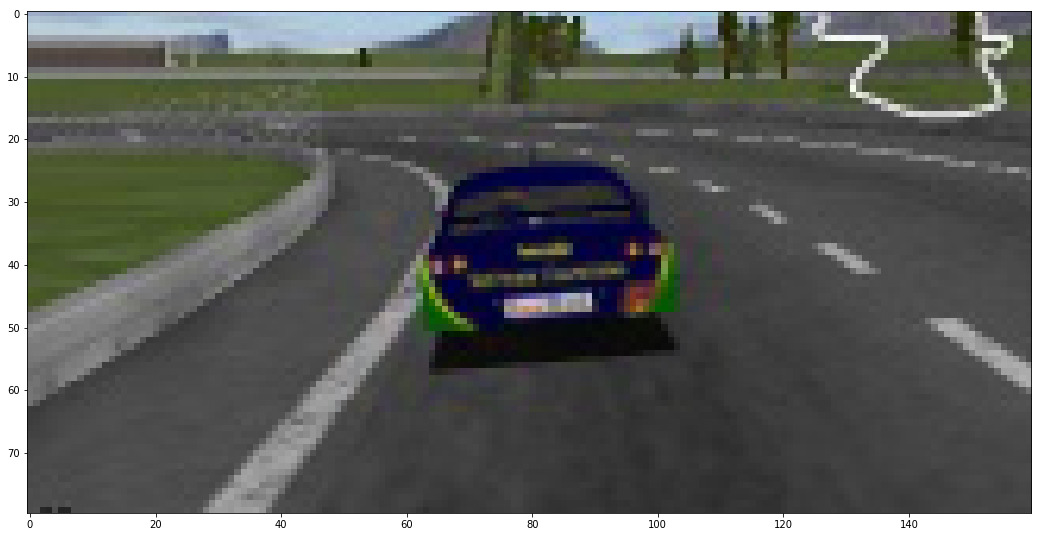

In [62]:
plt.figure(num=3, figsize=(18, 15),)
a = im_read(file_list[0])
a = cv2.resize(a,(160,80))
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
a = np.reshape(a , (1,) + a.shape)
#a = a/127.5 - 1.
plt.imshow(a[0])

In [60]:
src_img = np.asarray([   cv2.resize(cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB),(160,80))/127.5 - 1.  for i in file_list])


## load  model

####  设置环境变量，设置tf参数
#### 如果不启动tf session ，不用设置config

In [4]:
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
config.gpu_options.allow_growth = True

In [9]:
#sess = tf.InteractiveSession(config=config)
#sess = tf.Session(graph=tf.get_default_graph(), config=config)

### load keras model

In [8]:
from keras.models import load_model
from keras import backend as K

In [9]:
#sys.path.append('../research')

In [10]:
from models.autoencoder import generator , encoder ,get_model 
from models.interpolate import slerp

In [11]:
image_shape=(80, 160, 3)
gf_dim=64
df_dim=64
batch_size=64
ch = image_shape[2]
rows = [int(image_shape[0] / i) for i in [16, 8, 4, 2, 1]]
cols = [int(image_shape[1] / i) for i in [16, 8, 4, 2, 1]]
G = generator(None, gf_dim, ch, rows, cols)
E = encoder(None, df_dim, ch, rows, cols)
weights_path = lambda x : 'outputs/results_autoencoder/{}_weights.keras'.format(x)
G.load_weights(weights_path('G'))
E.load_weights(weights_path('E'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_h0_lin (Dense)             (None, 25600)             13132800  
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 10, 512)        0         
_________________________________________________________________
g_bn0 (BatchNormalization)   (None, 5, 10, 512)        2048      
_________________________________________________________________
activation_1 (Activation)    (None, 5, 10, 512)        0         
_________________________________________________________________
g_h1 (Conv2DTranspose)       (None, 10, 20, 256)       3277056   
_________________________________________________________________
g_bn1 (BatchNormalization)   (None, 10, 20, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 20, 256)       0         
__________

###### 必须设置 K.learning_phase()
启动batchnorma层

K.set_learning_phase(value=1) 将会把K.learning_phase() 设置为整数1，无法feed_dict赋值

### encoder

In [85]:
model = E
get_E_output = K.function([model.input, K.learning_phase()],
                                  model.outputs)
# output in train mode = 1
def E_predict(x):
    return get_E_output([x, 1])

In [84]:
E_output_1 = E_predict(src_img)

###### samplle a latant tensor

In [64]:
z1 = E_output_1[0] + np.random.normal(0.,1,E_output_1[0].shape)*E_output_1[1]

In [65]:
def get_slerp(codes, N = 20, z_dim = 512):
    shape = codes.shape
    code_a = codes[:int(shape[0] / 2)]
    code_a = np.reshape(code_a, [-1,  z_dim])
    code_b = codes[int(shape[0] / 2):]
    code_b = np.reshape(code_b, [-1,  z_dim])
    z_inter = []
    for low ,high in zip(code_a , code_b):
        for alpha in np.linspace(0., 1., N):
            interp_point = slerp(alpha, low , high)
            z_inter.append(interp_point)
    z_inter = np.asarray(z_inter)
    z_inter = np.reshape(z_inter, [-1, z_dim])
    return z_inter

In [66]:
z_inter = get_slerp(z1 ,)

In [67]:
z_inter.shape

(160, 512)

### generator

In [87]:
model = G
get_G_output = K.function([model.input, K.learning_phase()],
                                  model.outputs)

def G_predict(z):
    return get_G_output([z, 1])

In [88]:
G_output = G_predict(z_inter)

### 生成图像

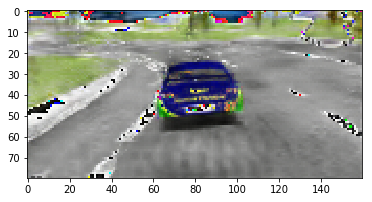

In [70]:
plt.imshow(G_output[0][0])

In [71]:
def cvt_imgs(decode_img ,src_img=None):

    size = decode_img.shape[0]
    N = int(size/8 +2)
    big_img = np.ones([80*8, 160*N, 3], np.float32)
    img_list = [None]*8*N
    for i in list(range(8)):
        img_list[N * i ] = src_img[i+8]
        img_list[N * i  + N - 1] = src_img[i ]

    index = 0
    for i in range(len(img_list)):
        if img_list[i] is   None:
            img_list[i] = decode_img[index][:]
            index +=1
    o_shape = [80,160]
    for i in range(8):
        for j in range(N):
            addimg = img_list[i * N + j][:]
            big_img[i * o_shape[0]:(i + 1) * o_shape[0], j * o_shape[1]:(j + 1) * o_shape[1]] = addimg
    big_img = (big_img + 1.)*255./2.
    big_img_rgb = cv2.cvtColor(big_img, cv2.COLOR_BGR2RGB)
    return big_img_rgb

In [82]:
big_img = cvt_imgs(G_output[0] , src_img )
cv2.imwrite('inference/{}.jpg'.format(int(time.time())),big_img)

True

1509961707